In [1]:
import pandas as pd

# Load Meta Ads and Shopify sample datasets
meta_df = pd.read_csv("../data/meta_ads_sample.csv")
shopify_df = pd.read_csv("../data/shopify_sales_sample.csv")

meta_df.head()


,campaign_id,campaign_name,date,spend,impressions,clicks,ctr,conversions,conversion_rate,revenue
0,1,Holiday Promo,2025-03-04,173.37,12270,513,0.0418,131,0.2554,7057.49
1,1,Holiday Promo,2025-03-05,123.23,11265,182,0.0162,49,0.2692,2648.19
2,1,Holiday Promo,2025-03-06,487.96,13322,144,0.0108,38,0.2639,1462.76
3,1,Holiday Promo,2025-03-07,346.99,10311,512,0.0497,113,0.2207,3421.94
4,1,Holiday Promo,2025-03-08,344.74,16096,348,0.0216,44,0.1264,1834.17


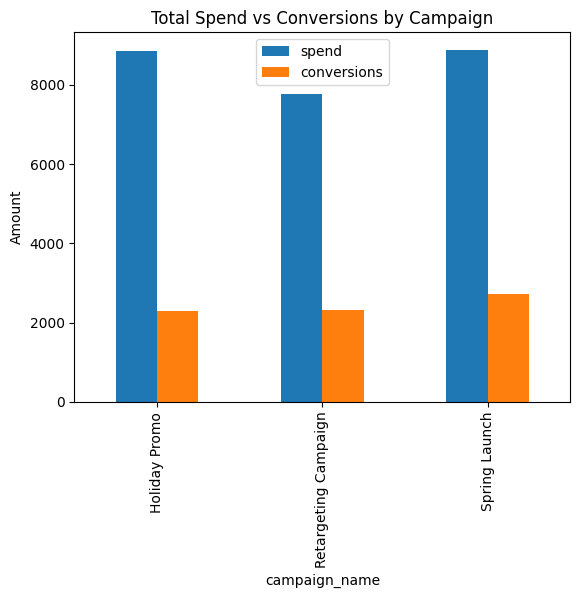

In [2]:
import matplotlib.pyplot as plt

# Example: Spend vs Conversions
meta_df.groupby("campaign_name")[["spend", "conversions"]].sum().plot(kind="bar")
plt.title("Total Spend vs Conversions by Campaign")
plt.ylabel("Amount")
plt.show()

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate by campaign
agg = meta_df.groupby("campaign_name")[["spend", "impressions", "clicks", "conversions", "revenue"]].sum()

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg)

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
agg["cluster"] = kmeans.fit_predict(X_scaled)

agg["performance_group"] = agg["cluster"].map({
    0: "High ROI",
    1: "Average",
    2: "Low ROI"
})

agg.reset_index()[["campaign_name", "performance_group"]]

agg


,spend,impressions,clicks,conversions,revenue,cluster,performance_group
campaign_name,,,,,,,
Holiday Promo,8845.19,404431,11384,2300,113713.09,2,Low ROI
Retargeting Campaign,7766.82,365084,11301,2312,116853.68,0,High ROI
Spring Launch,8881.73,380766,12770,2710,133635.25,1,Average


In [4]:
recommendations = []

for _, row in agg.iterrows():
    if row["performance_group"] == "High ROI":
        msg = f"🚀 *{row.name}* is performing well. Consider increasing budget by 15–20%."
    elif row["performance_group"] == "Low ROI":
        msg = f"⚠️ *{row.name}* has poor performance. Suggest reducing budget or testing new creatives."
    else:
        msg = f"🔍 *{row.name}* is average. Consider A/B testing audiences or adjusting spend gradually."
    recommendations.append(msg)

for rec in recommendations:
    print(rec)


⚠️ *Holiday Promo* has poor performance. Suggest reducing budget or testing new creatives.
🚀 *Retargeting Campaign* is performing well. Consider increasing budget by 15–20%.
🔍 *Spring Launch* is average. Consider A/B testing audiences or adjusting spend gradually.


In [5]:
# Save cluster assignments
agg.reset_index().to_csv("../data/meta_insights.csv", index=False)

# Save recommendations
with open("../data/meta_recommendations.txt", "w") as f:
    for rec in recommendations:
        f.write(rec + "\n")


In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

meta_df = pd.read_csv("../data/meta_ads_sample.csv")
meta_df["date"] = pd.to_datetime(meta_df["date"])
meta_df["day"] = (meta_df["date"] - meta_df["date"].min()).dt.days

# Aggregate by campaign and day
X = meta_df[["day", "spend", "impressions", "clicks", "ctr"]]
y = meta_df["conversions"]
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [7]:
# Simulate predictions for next 5 days at different spend levels
scenarios = []

for budget in [100, 250, 400, 500]:
    for day_offset in range(1, 6):
        day = X["day"].max() + day_offset
        impressions = budget * 40  # assume $1 ~ 40 impressions
        ctr = 0.03  # assume average CTR
        clicks = impressions * ctr

        X_future = pd.DataFrame([{
            "day": day,
            "spend": budget,
            "impressions": impressions,
            "clicks": clicks,
            "ctr": ctr
        }])

        predicted_conversions = model.predict(X_future)[0]

        scenarios.append({
            "day": day,
            "budget": budget,
            "predicted_conversions": round(predicted_conversions, 2)
        })

df_budget_forecast = pd.DataFrame(scenarios)
df_budget_forecast.to_csv("../data/predictive_budgeting.csv", index=False)
df_budget_forecast.head()


,day,budget,predicted_conversions
0,30,100,22.61
1,31,100,22.49
2,32,100,22.36
3,33,100,22.24
4,34,100,22.12


In [8]:
best = df_budget_forecast.groupby("budget")["predicted_conversions"].mean().idxmax()
recommendation = f"📊 Based on trends, a budget of ${best} yields the best conversion return."

with open("../data/predictive_budget_recommendation.txt", "w") as f:
    f.write(recommendation)
